# Lab_02 군집화

### Context
#### Clustering
+ k-means Clustering  
+ Hierarchical Clustering   
(비지도학습)
#### Evaluation
+ Silhouette : 군집화 결정확인해주는 측정


In [1]:
import os
from os.path import join
import copy
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import sklearn

import matplotlib.pyplot as plt

wine dataset load

In [4]:
from sklearn.datasets import load_wine
wine=load_wine()

이번 군집화 실습을 위해 sklearn 내장 데이터인 와인 데이터를 불러오겠습니다.<br>
와인 데이터셋은 알콜, 말산, 페놀(쓴맛)등 13개의 변수를 가지고 있으며, 1,2,3 와인 등급을 라벨 데이터로 가지고 있습니다.

In [ ]:
 print(wine.DESCR)

In [6]:
 data = wine.data
 label = wine.target
 columns = wine.feature_names

In [7]:
 data = pd.DataFrame(data,columns=columns)
 data.head(3)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0


In [8]:
 data.shape

(178, 13)

In [9]:
 data.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


In [10]:
 data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
dtypes: fl

## Clustering
클러스터링은 주어진 데이터들의 특성을 고려해 데이터 클러스터를 정의하고, 클러스터를 대표할 수 있는 대표점을 찾는 비지도 학습의 대표적인 알고리즘 입니다.<br>
간단히 말해서, 비슷한 특성을 가진 데이터끼리 묶는다고 말할 수 있습니다. 

### 1. k-Means 클러스터링
k-means 클러스터링은 대표적인 클러스터링 알고리즘 중 하나로, 각 클러스터에 할당된 데이터 포인트들의 평균 좌표를 이용해 중심점을 반복적으로 업데이트하며 클러스터를 형성하는 알고리즘 입니다.<br><br>
k-means Clustering 알고리즘은 3가지 단계로 이루어집니다.<br>
Step 1. 각 데이터 포인트 i 에 대해 가장 가까운
    중심점을 찾고, 그 중심점에 해당하는 클러스터를 할당합니다.
    <br>가까운 중심점을 찾을 때는, **유클리드 거리**를 사용합니다.<br>
Step 2. 할당된 클러스터를 기반으로 새로운 중심점을 계산합니다.
    중심점은 클러스터 내부 점들 좌표의 **산술 평균(mean)**
    으로 합니다.<br>
Step 3. 각 클러스터의 할당이 바뀌지 않을 때까지 반복합니다.

 ### 점과 점사이의 거리를 어떻게 측정할 수 있을까? 

 k-means clustering은 거리 기반 알고리즘이므로 여러가지 방법으로 거리를 측정할 수 있습니다.<br>
 #### 1. Manhattan Distance - 각 축에 대해 수직으로만 이동하여 계산하는 거리 측정방식
 $$D(x,y) = {{\sum_{i=1}^{d}  |x_i - y_i|} } $$
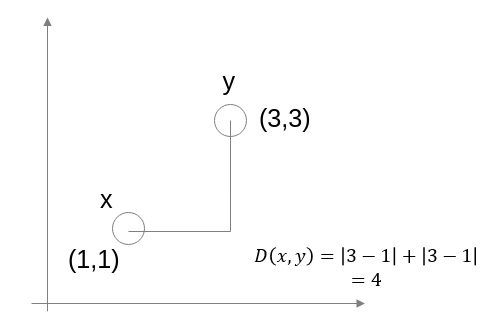 
 
 #### 2. Euclidean Distance - 점과 점사이의 가장 짧은 거리를 계산하는 거리 측정방식
 $$D(x,y) = {\sqrt{\sum_{i=1}^{d}  (x_i - y_i)^2} } $$
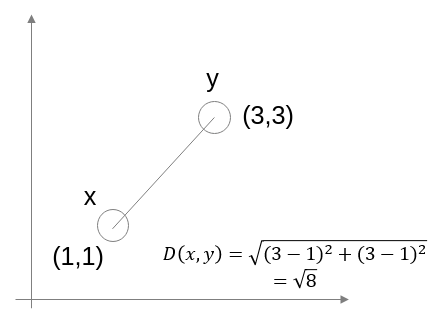  
 

#### 준비
wine 데이터는 13개의 컬럼을 가지고 있고, 하나의 데이터(행)는 13개의 차원으로 이루어진 벡터라고 볼 수 있습니다. <br>
13차원은 우리 눈으로 볼 수 있도록 표현하기 어려우므로 앞에서 배운 pca를 통해 2차원으로 만들어 시각화할 수 있도록 변환하겠습니다.<br>
그 전에 각 변수들의 값의 범위가 서로 다르므로 min-max 정규화를 통해 조정해주겠습니다.

In [11]:
#스케일러
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

In [12]:
#PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
data = pca.fit_transform(data)

In [13]:
 data.shape

(178, 2)

#### 1) 모델 불러오기 및 정의하기
클러스터링은 비지도학습이므로 클러스터의 수는 라벨의 수와 관계 없지만, 3개의 군집을 형성하도록 해보겠습니다.<br>
k-means 클러스터링은 sklearn의 cluster 패키지에 있습니다. 

In [14]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)

#### 2) 모델 학습하기 (클러스터링을 통한 중심점 찾기)

In [15]:
#모델이 3개의 클러스터로 할당된 중심점을 찾음 
kmeans.fit(data)

KMeans(n_clusters=3)

#### 3) 클러스터 할당

In [17]:
#어떤 군집에 속한지 클러스터 번호 반환 (인덱스 반환)
cluster = kmeans.predict(data)

In [18]:
cluster

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 1, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1], dtype=int32)

#### 4) 결과 살펴보기

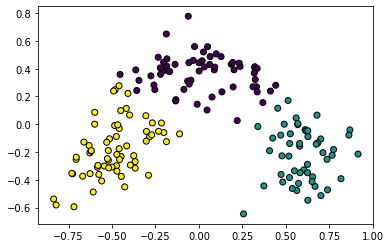

In [19]:
plt.scatter(data[:,0],data[:,1],c=cluster,edgecolor='black')
plt.show()

## 2. Hierarchical Clustering : 각자가1개 군집으로 생각하고 점점 묶어줌
Hierarchical Clustering은 거리(Distance) 또는 유사도(Similarity)를 기반으로 클러스터를 형성하는 알고리즘 입니다.<br> 
k-means Clustering과 다르게 클러스터의 수를 설정해 줄 필요가 없으며, 클러스터 형태를 시각적으로 표현해주는 덴드로그램을 통해 적절한 클러스터의 수를 선택할 수 있습니다.<br>
Hierachichal Clustering에는 Bottom-Up 방식의 Agglomerative Method와 Top-Down 방식의 Divisive Method로 나뉩니다.<br>
이번 단원에서는 Agglomerative Method를 사용해 실습을 진행합니다.
<br><br>Agglomerative Method를 사용한 Hierarchical Clustering 알고리즘은 3가지 단계로 이루어집니다.<br>
Step 1. 각 데이터 포인트를 클러스터로 할당합니다. (n개의 클러스터)<br>
Step 2. 가까운 클러스터끼리 병합합니다.<br>
Step 3. 1개의 클러스터가 될 때까지 반복합니다.

덴드로그램 바텀업 방식

### 어떻게 가장 가까운 클러스터를 찾을 수 있을까?
방금전 거리 측정 방법으로 맨하탄 거리, 유클리디언 거리에 대해 배웠었습니다.<br>
k-means에서는 각 클러스터의 중심점 간의 거리로 클러스터간 거리를 계산했었습니다.<br> 이번 수업에서는 새로운 클러스터간 거리를 계산하는 방법에 대해 알아보겠습니다.<br>
#### 1. Single Linkage - 두 클러스터 내의 가장 가까운 점 사이의 거리 
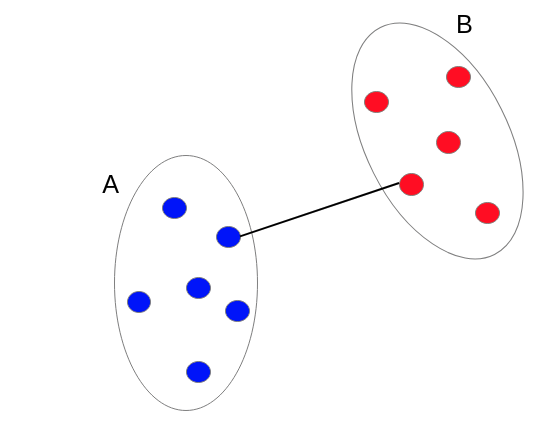 
#### 2. Complete Linkage - 두 클러스터 내의 가장 먼 점 사이의 거리
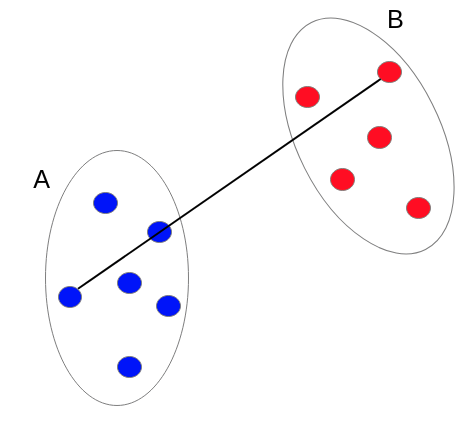 
#### 3. Average Linkage - 두 클러스터 내의 모든 점 사이의 평균 거리
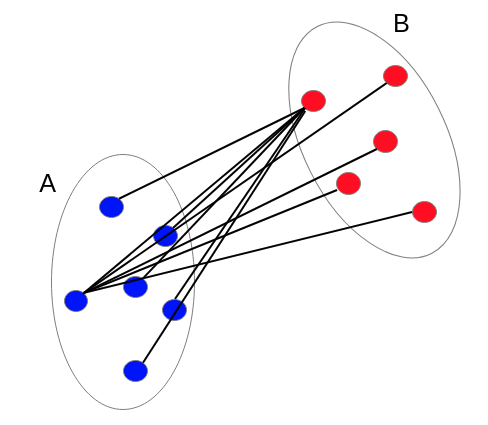

3개 거리 측정 방식의 결과와 차이점을 살펴보겠습니다.

### Single Linkage

#### 1) 모델 불러오기 및 정의하기

In [20]:
from sklearn.cluster import AgglomerativeClustering
single_clustering = AgglomerativeClustering(n_clusters=3,linkage='single')

#### 2) 모델 학습하기 (클러스터링을 통한 중심점 찾기)

In [21]:
#싱글링키지로 클러스터링 한 결과 
single_clustering.fit(data)

AgglomerativeClustering(linkage='single', n_clusters=3)

#### 3) 클러스터 할당

In [23]:
single_cluster = single_clustering.labels_
single_cluster

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

#### 4) 결과 살펴보기
* 산점도

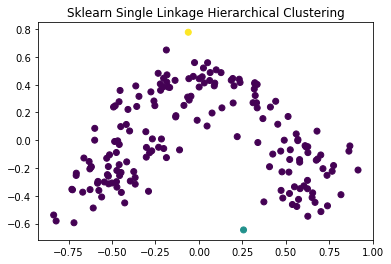

In [24]:
plt.scatter(data[:,0],data[:,1],c=single_cluster)
plt.title('Sklearn Single Linkage Hierarchical Clustering')
plt.show()
#제대로 분류가 안되었다

* 덴드로그램

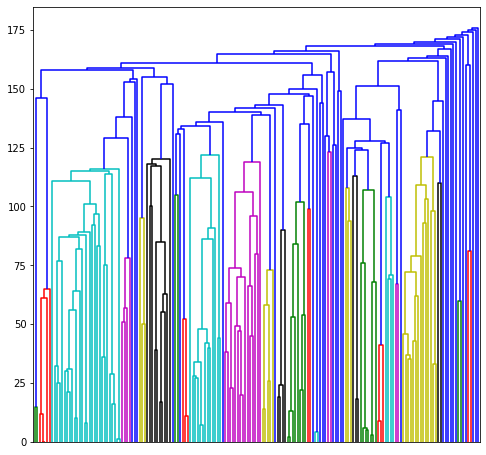

In [26]:
from scipy.spatial import distance
from scipy.cluster.hierarchy import dendrogram
plt.figure(figsize=(8,8))

# Hierarchical Clustering의 자식 노드
children = single_clustering.children_
# 각 자식 노드간의 거리 정보를 가지고 있지 않기 때문에, 균일하게 그리도록 합니다.
distance = np.arange(children.shape[0])
# 각 클러스터 단계를 포함한 노드의 수 계산
no_of_observations = np.arange(2,children.shape[0]+2)
# 덴드로그램을 그리기위한 연결 매트릭스를 생성합니다.
linkage_matrix = np.column_stack([children,distance,no_of_observations]).astype(float)
# 덴드로그램을 그립니다.
dendrogram(linkage_matrix,p=len(data),labels=single_cluster,show_contracted=True,no_labels=True)
plt.show()

### Complete Linkage

#### 1) 모델 불러오기 및 정의하기

In [27]:
complete_clustering = AgglomerativeClustering(n_clusters=3,linkage='complete')

#### 2) 모델 학습하기 (클러스터링을 통한 중심점 찾기)

In [28]:
complete_clustering.fit(data)

AgglomerativeClustering(linkage='complete', n_clusters=3)

#### 3) 클러스터 할당

In [32]:
complete_cluster = complete_clustering.labels_ 

#### 4) 결과 살펴보기
* 산점도

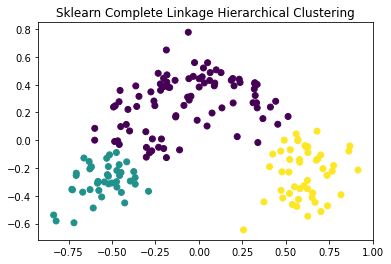

In [33]:
plt.scatter(data[:,0],data[:,1],c=complete_cluster)
plt.title('Sklearn Complete Linkage Hierarchical Clustering')
plt.show()

* 덴드로그램

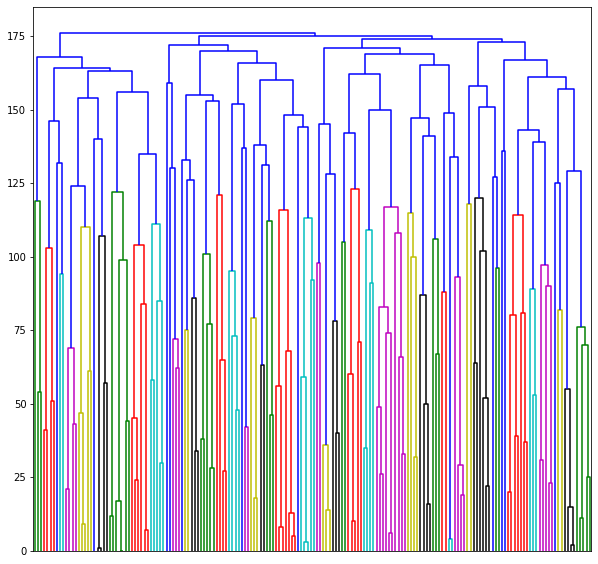

In [34]:
from scipy.cluster.hierarchy import dendrogram
plt.figure(figsize=(10,10))

# Hierarchical Clustering의 자식 노드
children = complete_clustering.children_

# 각 자식 노드간의 거리 정보를 가지고 있지 않기 때문에, 균일하게 그리도록 합니다.
distance = np.arange(children.shape[0])

# 각 클러스터 단계를 포함한 노드의 수 계산
no_of_observations = np.arange(2,children.shape[0]+2)

# 덴드로그램을 그리기위한 연결 매트릭스를 생성합니다.
linkage_matrix = np.column_stack([children,distance,no_of_observations]).astype(float)

# 덴드로그램을 그립니다.
dendrogram(linkage_matrix,p=len(data),labels=complete_cluster,show_contracted=True,no_labels=True)
plt.show()
 

### Average Linkage

#### 1) 모델 불러오기 및 정의하기

In [35]:
average_clustering = AgglomerativeClustering(n_clusters=3,linkage='average')

#### 2) 모델 학습하기 (클러스터링을 통한 중심점 찾기)

In [36]:
average_clustering.fit(data)

AgglomerativeClustering(linkage='average', n_clusters=3)

#### 3) 클러스터 할당

In [37]:
average_cluster = average_clustering.labels_ 

#### 4) 결과 살펴보기
* 산점도

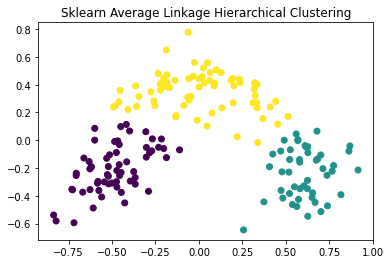

In [38]:
plt.scatter(data[:,0],data[:,1],c=average_cluster)
plt.title('Sklearn Average Linkage Hierarchical Clustering')
plt.show()
 

* 덴드로그램

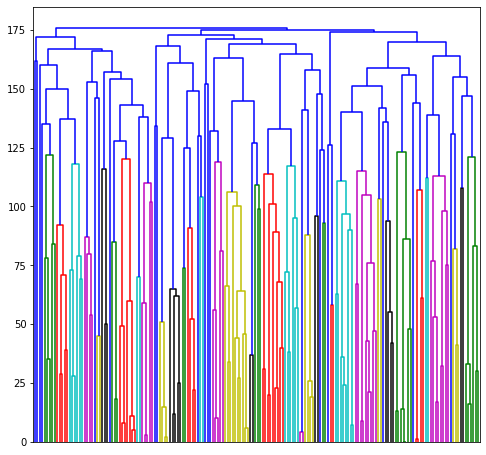

In [39]:
from scipy.cluster.hierarchy import dendrogram
plt.figure(figsize=(8,8))

# Hierarchical Clustering의 자식 노드
children = average_clustering.children_

# 각 자식 노드간의 거리 정보를 가지고 있지 않기 때문에, 균일하게 그리도록 합니다.
distance = np.arange(children.shape[0])

# 각 클러스터 단계를 포함한 노드의 수 계산
no_of_observations = np.arange(2,children.shape[0]+2)

# 덴드로그램을 그리기위한 연결 매트릭스를 생성합니다.
linkage_matrix = np.column_stack([children,distance,no_of_observations]).astype(float)

# 덴드로그램을 그립니다.
dendrogram(linkage_matrix,p=len(data),labels=average_cluster,show_contracted=True,no_labels=True)
plt.show()

### 클러스터링 결과 비교하기
1. Single Linkage
    + 두 클러스터 내의 가장 가까운 점을 기준으로 클러스터를 합치기 클러스터 사이의 노이즈에 매우 민감한 특성과 구 형태가 아닌 데이터에 대해 클러스터를 잘 형성한다는 특성이 있습니다.
    + wine 데이터는 모든 데이터가 연결되어 있는 듯한 분포를 가지고 있기 때문에, 각 클러스터의 경계가 모호한 노이즈가 많은 형태를 띠고 있습니다. <br>Single Linkage가 구 형태가 아닌 데이터에 대해 클러스터를 잘 형성한다는 특성이 있지만, 이러한 데이터의 경우 Single Linkage 방법을 사용하면 좋은 클러스터를 생성하기 어렵습니다.

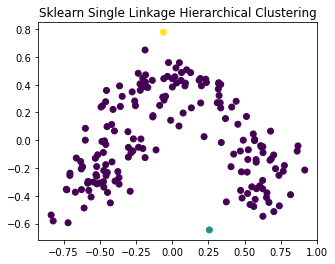

In [40]:
plt.figure(figsize=(5,4))

plt.scatter(data[:,0],data[:,1],c=single_cluster)
plt.title('Sklearn Single Linkage Hierarchical Clustering')
plt.show()

2. Complete Linkage
    + 두 클러스터 내에 가장 먼 점을 기준으로 클러스터를 합치기 때문에 클러스터 사이의 노이즈와 이상치에 민감하지 않은 특성이 있습니다.
    + 노이즈에 민감하지 않다는 특성을 가진 Complete Linkage가 좋은 성능을 보여주었습니다. 
3. Average Linkage
    + Single Linkage와 Complete Linkage의 중간쯤에 위치한 Average Linkage가 가장 정답에 가까운 클러스터를 형성한 것을 확인할 수 있습니다. 

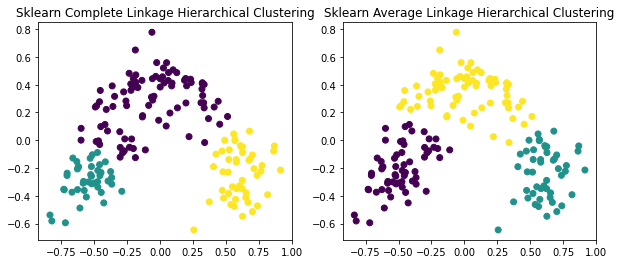

In [41]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.scatter(data[:,0],data[:,1],c=complete_cluster)
plt.title('Sklearn Complete Linkage Hierarchical Clustering')

plt.subplot(1,2,2)
plt.scatter(data[:,0],data[:,1],c=average_cluster)
plt.title('Sklearn Average Linkage Hierarchical Clustering')
plt.show()

## Evaluation
### Silhouette : 그냥 보여주는것 보다 수치를 보여주는것이 좋음
+ 실루엣 값은 한 클러스터 안의 데이터들이 다른 클러스터와 비교해서 얼마나 비슷한가를 나타냅니다.<br>
+ 같은 클러스터 내의 점들간 거리는 가깝고(cohesion) 서로 다른 클러스터 간의 거리는 멀수록(separation) 높은 값을 얻을 수 있습니다.<br>
+ 실루엣 값이 1에 근접한다는 것은 같은 클러스터 내의 평균거리가 다른 클러스터와의 평균거리보다 가깝다는 것을 의미합니다.
+ 일반적으로 실루엣 값이 0.5보다 크다면 데이터가 잘 클러스터링 되었다는 것을 나타냅니다.

실루엣 공식은 다음과 같습니다.
$$ S_i = { {(b_i - a_i)} \over max(a_i, b_i) }$$

$$ a_i\ :\ 같은\ 클러스터\ 내의\ 모든\ 점들\ 간\ 평균\ 거리 $$
$$ b_i\ :\ \bar d\ =\ (i,c)의\ 최솟값 $$
$$ \bar d\ =\ (i,c)\ :\ 다른\ 클러스터\ c와\ i번째 데이터 와의\ 평균\ 거리$$
<br>

직관적으로 수식을 이해해보겠습니다. a<sub>i</sub>는 같은 클러스터 내의 데이터 들이 잘 모여있다면 적은 값을 나타내고, b<sub>i</sub>는 각 클러스터들이 멀리 떨어져있다면 큰 값을 나타내게 됩니다.<br>
따라서 수식 S<sub>i</sub>에 따르면, 아주 잘 형성된(같은 클러스터는 가깝고 다른 클러스터끼리는 먼) 클러스터 형태일 때 분모는 b<sub>i</sub>이 되고,<br> 분자는 b<sub>i</sub>에서 아주 작은 값인 a<sub>i</sub>가 빠져 1에 가까운 실루엣 값을 얻을 수 있습니다.

#### 가장 좋은 클러스터를 형성하는 클러스터의 수를 찾아보자
k-means 클러스터링과 Average Linkage를 사용한 Hierarchical 클러스터링에서 가장 높은 점수의 클러스터 수는 무엇인지 알아보겠습니다.

Silhouette 스코어링은 Sklearn의 metrics 패키지에 있습니다.

#### 1) k-means에 대한 실루엣값

In [42]:
#가장높은 점수의 실루엣 점수 찾기
from sklearn.metrics import silhouette_score

In [44]:
best_n = 1
best_score = -1

for n_cluster in range(2, 11):
    kmeans = KMeans(n_clusters=n_cluster)
    kmeans.fit(data)
    cluster = kmeans.predict(data)
    score = silhouette_score(data,cluster)  #유클리디안 거리를 사용


    print('클러스터의 수 : {}, 실루엣 점수 : {:.2f}'.format(n_cluster,score))
    if score > best_score : #갱신반복문
        best_n = n_cluster
        best_score = score
        
print('가장 높은 실루엣 점수를 가진 클러스터 수 : {}, 실루엣 점수 : {:.2f}'.format(best_n,best_score))

클러스터의 수 : 2, 실루엣 점수 : 0.49
클러스터의 수 : 3, 실루엣 점수 : 0.57
클러스터의 수 : 4, 실루엣 점수 : 0.49
클러스터의 수 : 5, 실루엣 점수 : 0.46
클러스터의 수 : 6, 실루엣 점수 : 0.43
클러스터의 수 : 7, 실루엣 점수 : 0.38
클러스터의 수 : 8, 실루엣 점수 : 0.41
클러스터의 수 : 9, 실루엣 점수 : 0.39
클러스터의 수 : 10, 실루엣 점수 : 0.39
가장 높은 실루엣 점수를 가진 클러스터 수 : 3, 실루엣 점수 : 0.57


#### 2) Average Linkage Hierarchical Clustering

In [45]:
best_n = 1
best_score = -1

for n_cluster in range(2, 11):
    average_clustering = AgglomerativeClustering(n_clusters=n_cluster,linkage='average')
    average_clustering.fit(data)
    cluster = average_clustering.labels_
    score = silhouette_score(data,cluster)  #유클리디안 거리를 사용


    print('클러스터의 수 : {}, 실루엣 점수 : {:.2f}'.format(n_cluster,score))
    if score > best_score : #갱신반복문
        best_n = n_cluster
        best_score = score
        
print('가장 높은 실루엣 점수를 가진 클러스터 수 : {}, 실루엣 점수 : {:.2f}'.format(best_n,best_score))

클러스터의 수 : 2, 실루엣 점수 : 0.49
클러스터의 수 : 3, 실루엣 점수 : 0.56
클러스터의 수 : 4, 실루엣 점수 : 0.48
클러스터의 수 : 5, 실루엣 점수 : 0.42
클러스터의 수 : 6, 실루엣 점수 : 0.37
클러스터의 수 : 7, 실루엣 점수 : 0.34
클러스터의 수 : 8, 실루엣 점수 : 0.34
클러스터의 수 : 9, 실루엣 점수 : 0.37
클러스터의 수 : 10, 실루엣 점수 : 0.33
가장 높은 실루엣 점수를 가진 클러스터 수 : 3, 실루엣 점수 : 0.56


### Reference
- Wikipedia, Clustering : https://ko.wikipedia.org/wiki/클러스터_분석
- Wikipedia, Manhattan distance : https://ko.wikipedia.org/wiki/맨해튼_거리
- Wikipedia, Euclidean distance : https://ko.wikipedia.org/wiki/유클리드_거리
- Sklearn, Wine dataset : https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html
- Sklearn, k-Means Clustering : https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
- Sklearn, Hierarchical Clustering : https://www.google.com/url?q=http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html&sa=U&ved=0ahUKEwj_2aiGvt7hAhXLi7wKHei8CNsQFggEMAA&client=internal-uds-cse&cx=016639176250731907682:tjtqbvtvij0&usg=AOvVaw0zVZAVTxgORo-7LbgrNv_o
- Sklearn, Silhouette : https://www.google.com/url?q=http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html&sa=U&ved=0ahUKEwi5lrTZwd7hAhUqCqYKHWCZCTEQFggEMAA&client=internal-uds-cse&cx=016639176250731907682:tjtqbvtvij0&usg=AOvVaw0-ZT8AJZRmR-qNpN-62Ei-
- Sklearn, Silhouette Example : https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py
- Scipy, Dendrogram : https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.cluster.hierarchy.dendrogram.html